<a href="https://colab.research.google.com/github/yasaswini2004/Fruit-Quality-Prediction/blob/main/Fruit-Quality-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aids-data-quest-society:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F70769%2F7731816%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T105825Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a0d1c682dc785ca0cf6cfa539c9d55c0d825c34762dd4468f235c90d39df0a7555007f692a68600adc0835875ddb050706ab0d6cc57d4bcbfc6884224a640d967a7d7780f049c7f4b397f7f13049fdd7868ea230d9ba7fdd278796daad66e1aa82a3dbc58ca155f74b7ba4b422b470c411feca235717448d860d2eca8c262d9931fd598427f5e4dadf59c6c6103a5fd5066471ad04e485491d9efac5c542388fd421a129d712c8c2bd575957c36e7778a32d18d906637f52bbe24ac1b7a797778deaea2237bb76bb6a5dfc0e61453dec47f0e13e4d1deb8b3d90cfc909a5132b2fa95a0199077bbe2d9ed650fa0d2f404b8f0f89eb7f775203f1e233d841e0f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 181426 bytes downloaded
Downloaded and uncompressed: aids-data-quest-society
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aids-data-quest-society/test_ds.csv
/kaggle/input/aids-data-quest-society/train_ds.csv
/kaggle/input/aids-data-quest-society/sample_submission.csv


<function matplotlib.pyplot.show(close=None, block=None)>

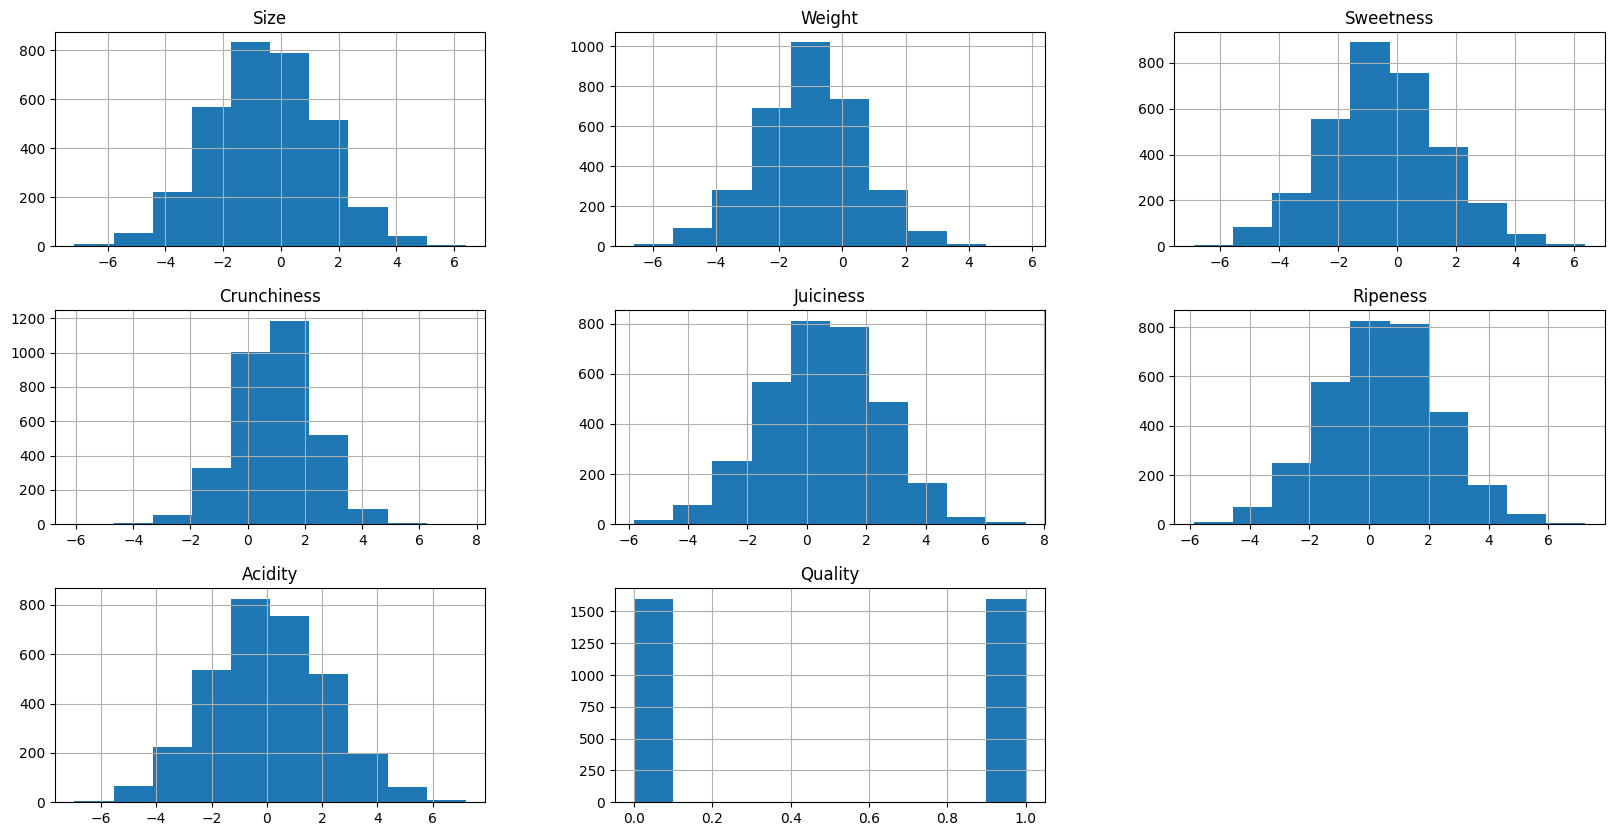

In [3]:
train_df = pd.read_csv('/content/train_ds.csv', index_col=0)
train_df.dropna(inplace=True)
train_df['Acidity'] = train_df['Acidity'].astype(float)
train_df['Quality'] = train_df['Quality'].map({"good": 1, "bad": 0})
plt.rcParams['figure.figsize']=[20,10]
train_df.hist()
plt.show

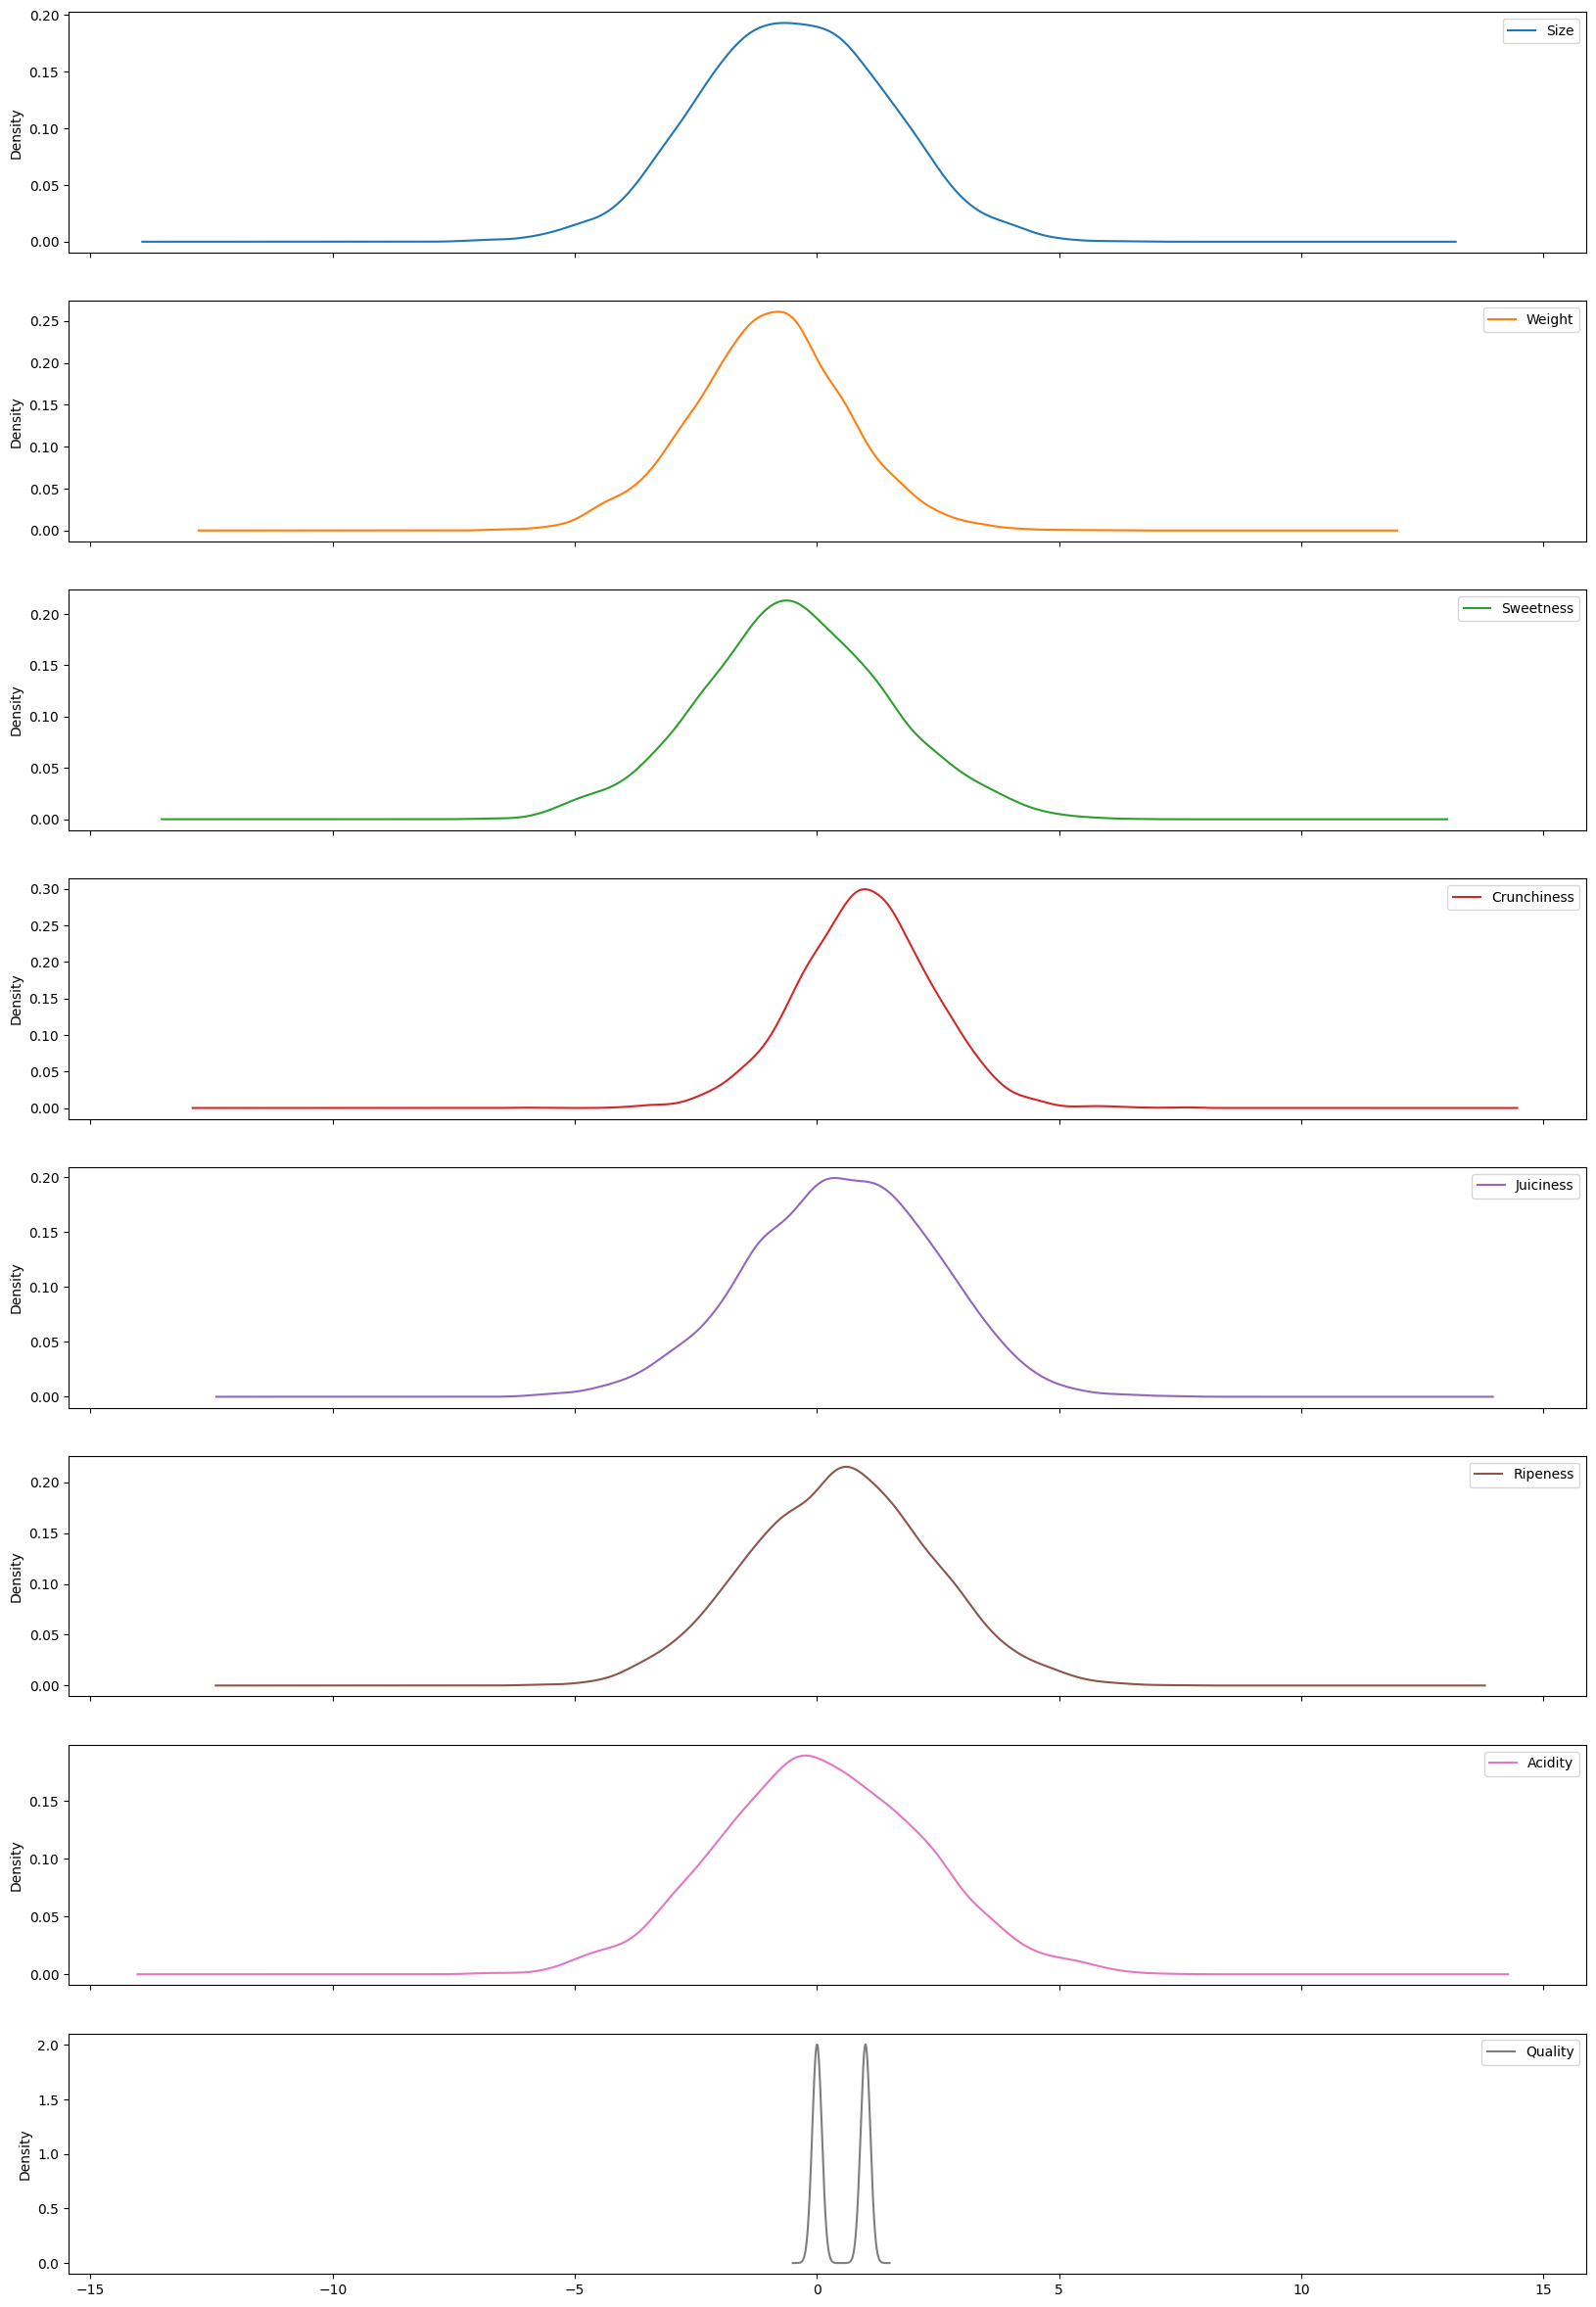

In [4]:
plt.rcParams['figure.figsize']=[20,30]
train_df.plot(kind='density',subplots=True,sharex=True)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_df.iloc[:, :-1])
x_train = scaled_train
y_train = train_df['Quality'].values
input_shape = [x_train.shape[1]]

In [6]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 7)                 28        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2048      
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               5

In [7]:
model.summary()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='binary_accuracy'
)
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 7)                 28        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2048      
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               5

50/50 [==============================] - 2s 6ms/step - loss: 0.4741 - binary_accuracy: 0.7709
Epoch 2/100
42/50 [========================>.....] - ETA: 0s - loss: 0.3448 - binary_accuracy: 0.8423

50/50 [==============================] - 0s 5ms/step - loss: 0.3475 - binary_accuracy: 0.8406
Epoch 3/100
34/50 [===================>..........] - ETA: 0s - loss: 0.3179 - binary_accuracy: 0.8631

50/50 [==============================] - 0s 4ms/step - loss: 0.3103 - binary_accuracy: 0.8669
Epoch 4/100
49/50 [============================>.] - ETA: 0s - loss: 0.2949 - binary_accuracy: 0.8744

50/50 [==============================] - 0s 3ms/step - loss: 0.2945 - binary_accuracy: 0.8747
Epoch 5/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2944 - binary_accuracy: 0.8721

50/50 [==============================] - 0s 4ms/step - loss: 0.2926 - binary_accuracy: 0.8731
Epoch 6/100
34/50 [===================>..........] - ETA: 0s - loss: 0.2802 - binary_accuracy: 0.8773

50/50 [==============================] - 0s 3ms/step - loss: 0.2782 - binary_accuracy: 0.8772
Epoch 7/100
35/50 [====================>.........] - ETA: 0s - loss: 0.2620 - binary_accuracy: 0.8871

50/50 [==============================] - 0s 3ms/step - loss: 0.2620 - binary_accuracy: 0.8878
Epoch 8/100
47/50 [===========================>..] - ETA: 0s - loss: 0.2536 - binary_accuracy: 0.8916

50/50 [==============================] - 0s 4ms/step - loss: 0.2512 - binary_accuracy: 0.8931
Epoch 9/100
35/50 [====================>.........] - ETA: 0s - loss: 0.2462 - binary_accuracy: 0.8951

50/50 [==============================] - 0s 3ms/step - loss: 0.2475 - binary_accuracy: 0.8922
Epoch 10/100
49/50 [============================>.] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.8925

50/50 [==============================] - 0s 3ms/step - loss: 0.2457 - binary_accuracy: 0.8922
Epoch 11/100
35/50 [====================>.........] - ETA: 0s - loss: 0.2337 - binary_accuracy: 0.9094

50/50 [==============================] - 0s 3ms/step - loss: 0.2355 - binary_accuracy: 0.9075
Epoch 12/100
49/50 [============================>.] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9034

50/50 [==============================] - 0s 3ms/step - loss: 0.2344 - binary_accuracy: 0.9022
Epoch 13/100
35/50 [====================>.........] - ETA: 0s - loss: 0.2160 - binary_accuracy: 0.9121

50/50 [==============================] - 0s 3ms/step - loss: 0.2168 - binary_accuracy: 0.9150
Epoch 14/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2058 - binary_accuracy: 0.9186

50/50 [==============================] - 0s 3ms/step - loss: 0.2056 - binary_accuracy: 0.9187
Epoch 15/100
35/50 [====================>.........] - ETA: 0s - loss: 0.2177 - binary_accuracy: 0.9138

50/50 [==============================] - 0s 3ms/step - loss: 0.2162 - binary_accuracy: 0.9103
Epoch 16/100
50/50 [==============================] - ETA: 0s - loss: 0.2000 - binary_accuracy: 0.9153

50/50 [==============================] - 0s 3ms/step - loss: 0.2000 - binary_accuracy: 0.9153
Epoch 17/100
50/50 [==============================] - ETA: 0s - loss: 0.2010 - binary_accuracy: 0.9162

50/50 [==============================] - 0s 3ms/step - loss: 0.2010 - binary_accuracy: 0.9162
Epoch 18/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1948 - binary_accuracy: 0.9214

50/50 [==============================] - 0s 3ms/step - loss: 0.1935 - binary_accuracy: 0.9222
Epoch 19/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1873 - binary_accuracy: 0.9259

50/50 [==============================] - 0s 4ms/step - loss: 0.1955 - binary_accuracy: 0.9225
Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 0.1901 - binary_accuracy: 0.9225

50/50 [==============================] - 0s 3ms/step - loss: 0.1905 - binary_accuracy: 0.9219
Epoch 21/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1948 - binary_accuracy: 0.9183

50/50 [==============================] - 0s 3ms/step - loss: 0.1925 - binary_accuracy: 0.9187
Epoch 22/100
49/50 [============================>.] - ETA: 0s - loss: 0.1917 - binary_accuracy: 0.9241

50/50 [==============================] - 0s 3ms/step - loss: 0.1911 - binary_accuracy: 0.9241
Epoch 23/100
47/50 [===========================>..] - ETA: 0s - loss: 0.2005 - binary_accuracy: 0.9176

50/50 [==============================] - 0s 3ms/step - loss: 0.1965 - binary_accuracy: 0.9194
Epoch 24/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1815 - binary_accuracy: 0.9272

50/50 [==============================] - 0s 3ms/step - loss: 0.1840 - binary_accuracy: 0.9250
Epoch 25/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1973 - binary_accuracy: 0.9246

50/50 [==============================] - 0s 3ms/step - loss: 0.1830 - binary_accuracy: 0.9300
Epoch 26/100
47/50 [===========================>..] - ETA: 0s - loss: 0.1845 - binary_accuracy: 0.9295

50/50 [==============================] - 0s 3ms/step - loss: 0.1847 - binary_accuracy: 0.9294
Epoch 27/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1765 - binary_accuracy: 0.9265

50/50 [==============================] - 0s 3ms/step - loss: 0.1826 - binary_accuracy: 0.9228
Epoch 28/100
47/50 [===========================>..] - ETA: 0s - loss: 0.1782 - binary_accuracy: 0.9272

50/50 [==============================] - 0s 3ms/step - loss: 0.1785 - binary_accuracy: 0.9272
Epoch 29/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1638 - binary_accuracy: 0.9371

50/50 [==============================] - 0s 3ms/step - loss: 0.1758 - binary_accuracy: 0.9322
Epoch 30/100
50/50 [==============================] - ETA: 0s - loss: 0.1782 - binary_accuracy: 0.9219

50/50 [==============================] - 0s 3ms/step - loss: 0.1782 - binary_accuracy: 0.9219
Epoch 31/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1690 - binary_accuracy: 0.9335

50/50 [==============================] - 0s 3ms/step - loss: 0.1705 - binary_accuracy: 0.9322
Epoch 32/100
47/50 [===========================>..] - ETA: 0s - loss: 0.1664 - binary_accuracy: 0.9328

50/50 [==============================] - 0s 4ms/step - loss: 0.1697 - binary_accuracy: 0.9319
Epoch 33/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1794 - binary_accuracy: 0.9269

50/50 [==============================] - 0s 3ms/step - loss: 0.1759 - binary_accuracy: 0.9300
Epoch 34/100
46/50 [==========================>...] - ETA: 0s - loss: 0.1812 - binary_accuracy: 0.9266

50/50 [==============================] - 0s 3ms/step - loss: 0.1844 - binary_accuracy: 0.9269
Epoch 35/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1626 - binary_accuracy: 0.9324

50/50 [==============================] - 0s 3ms/step - loss: 0.1752 - binary_accuracy: 0.9312
Epoch 36/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1701 - binary_accuracy: 0.9292

50/50 [==============================] - 0s 3ms/step - loss: 0.1700 - binary_accuracy: 0.9294
Epoch 37/100
46/50 [==========================>...] - ETA: 0s - loss: 0.1747 - binary_accuracy: 0.9317

50/50 [==============================] - 0s 4ms/step - loss: 0.1740 - binary_accuracy: 0.9325
Epoch 38/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1644 - binary_accuracy: 0.9333

50/50 [==============================] - 0s 3ms/step - loss: 0.1633 - binary_accuracy: 0.9344
Epoch 39/100
49/50 [============================>.] - ETA: 0s - loss: 0.1720 - binary_accuracy: 0.9263

50/50 [==============================] - 0s 3ms/step - loss: 0.1723 - binary_accuracy: 0.9269
Epoch 40/100
50/50 [==============================] - ETA: 0s - loss: 0.1518 - binary_accuracy: 0.9381

50/50 [==============================] - 0s 3ms/step - loss: 0.1518 - binary_accuracy: 0.9381
Epoch 41/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1729 - binary_accuracy: 0.9304

50/50 [==============================] - 0s 3ms/step - loss: 0.1606 - binary_accuracy: 0.9375
Epoch 42/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1651 - binary_accuracy: 0.9357

50/50 [==============================] - 0s 3ms/step - loss: 0.1634 - binary_accuracy: 0.9372
Epoch 43/100
49/50 [============================>.] - ETA: 0s - loss: 0.1619 - binary_accuracy: 0.9346

50/50 [==============================] - 0s 3ms/step - loss: 0.1636 - binary_accuracy: 0.9337
Epoch 44/100
49/50 [============================>.] - ETA: 0s - loss: 0.1605 - binary_accuracy: 0.9378

50/50 [==============================] - 0s 3ms/step - loss: 0.1626 - binary_accuracy: 0.9378
Epoch 45/100
49/50 [============================>.] - ETA: 0s - loss: 0.1601 - binary_accuracy: 0.9321

50/50 [==============================] - 0s 3ms/step - loss: 0.1600 - binary_accuracy: 0.9325
Epoch 46/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1670 - binary_accuracy: 0.9344

50/50 [==============================] - 0s 3ms/step - loss: 0.1626 - binary_accuracy: 0.9341
Epoch 47/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1684 - binary_accuracy: 0.9310

50/50 [==============================] - 0s 3ms/step - loss: 0.1672 - binary_accuracy: 0.9316
Epoch 48/100
47/50 [===========================>..] - ETA: 0s - loss: 0.1665 - binary_accuracy: 0.9315

50/50 [==============================] - 0s 4ms/step - loss: 0.1655 - binary_accuracy: 0.9316
Epoch 49/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1702 - binary_accuracy: 0.9344

50/50 [==============================] - 0s 3ms/step - loss: 0.1669 - binary_accuracy: 0.9322
Epoch 50/100
49/50 [============================>.] - ETA: 0s - loss: 0.1582 - binary_accuracy: 0.9356

50/50 [==============================] - 0s 3ms/step - loss: 0.1587 - binary_accuracy: 0.9350
Epoch 51/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1631 - binary_accuracy: 0.9349

50/50 [==============================] - 0s 3ms/step - loss: 0.1616 - binary_accuracy: 0.9353
Epoch 52/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1460 - binary_accuracy: 0.9451

50/50 [==============================] - 0s 3ms/step - loss: 0.1581 - binary_accuracy: 0.9388
Epoch 53/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1671 - binary_accuracy: 0.9353

50/50 [==============================] - 0s 3ms/step - loss: 0.1652 - binary_accuracy: 0.9347
Epoch 54/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1409 - binary_accuracy: 0.9402

50/50 [==============================] - 0s 3ms/step - loss: 0.1512 - binary_accuracy: 0.9359
Epoch 55/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1602 - binary_accuracy: 0.9379

50/50 [==============================] - 0s 3ms/step - loss: 0.1634 - binary_accuracy: 0.9359
Epoch 56/100
46/50 [==========================>...] - ETA: 0s - loss: 0.1636 - binary_accuracy: 0.9375

50/50 [==============================] - 0s 4ms/step - loss: 0.1588 - binary_accuracy: 0.9394
Epoch 57/100
50/50 [==============================] - ETA: 0s - loss: 0.1525 - binary_accuracy: 0.9447

50/50 [==============================] - 0s 3ms/step - loss: 0.1525 - binary_accuracy: 0.9447
Epoch 58/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1653 - binary_accuracy: 0.9283

50/50 [==============================] - 0s 3ms/step - loss: 0.1524 - binary_accuracy: 0.9344
Epoch 59/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1610 - binary_accuracy: 0.9347

50/50 [==============================] - 0s 3ms/step - loss: 0.1531 - binary_accuracy: 0.9378
Epoch 60/100
50/50 [==============================] - ETA: 0s - loss: 0.1590 - binary_accuracy: 0.9359

50/50 [==============================] - 0s 3ms/step - loss: 0.1590 - binary_accuracy: 0.9359
Epoch 61/100
47/50 [===========================>..] - ETA: 0s - loss: 0.1501 - binary_accuracy: 0.9372

50/50 [==============================] - 0s 5ms/step - loss: 0.1501 - binary_accuracy: 0.9369
Epoch 62/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1568 - binary_accuracy: 0.9317

50/50 [==============================] - 0s 5ms/step - loss: 0.1550 - binary_accuracy: 0.9328
Epoch 63/100
42/50 [========================>.....] - ETA: 0s - loss: 0.1354 - binary_accuracy: 0.9505

50/50 [==============================] - 0s 5ms/step - loss: 0.1434 - binary_accuracy: 0.9475
Epoch 64/100
50/50 [==============================] - ETA: 0s - loss: 0.1629 - binary_accuracy: 0.9353

50/50 [==============================] - 0s 5ms/step - loss: 0.1629 - binary_accuracy: 0.9353
Epoch 65/100
44/50 [=========================>....] - ETA: 0s - loss: 0.1594 - binary_accuracy: 0.9375

50/50 [==============================] - 0s 5ms/step - loss: 0.1545 - binary_accuracy: 0.9394
Epoch 66/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1603 - binary_accuracy: 0.9302

50/50 [==============================] - 0s 5ms/step - loss: 0.1576 - binary_accuracy: 0.9322
Epoch 67/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1618 - binary_accuracy: 0.9342

50/50 [==============================] - 0s 5ms/step - loss: 0.1584 - binary_accuracy: 0.9353
Epoch 68/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1456 - binary_accuracy: 0.9434

50/50 [==============================] - 0s 5ms/step - loss: 0.1490 - binary_accuracy: 0.9409
Epoch 69/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1422 - binary_accuracy: 0.9408

50/50 [==============================] - 0s 5ms/step - loss: 0.1437 - binary_accuracy: 0.9400
Epoch 70/100
41/50 [=======================>......] - ETA: 0s - loss: 0.1412 - binary_accuracy: 0.9440

50/50 [==============================] - 0s 5ms/step - loss: 0.1440 - binary_accuracy: 0.9438
Epoch 71/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1436 - binary_accuracy: 0.9469

50/50 [==============================] - 0s 4ms/step - loss: 0.1500 - binary_accuracy: 0.9419
Epoch 72/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1525 - binary_accuracy: 0.9401

50/50 [==============================] - 0s 3ms/step - loss: 0.1514 - binary_accuracy: 0.9409
Epoch 73/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9370

50/50 [==============================] - 0s 3ms/step - loss: 0.1545 - binary_accuracy: 0.9356
Epoch 74/100
44/50 [=========================>....] - ETA: 0s - loss: 0.1380 - binary_accuracy: 0.9421

50/50 [==============================] - 0s 4ms/step - loss: 0.1394 - binary_accuracy: 0.9419
Epoch 75/100
50/50 [==============================] - ETA: 0s - loss: 0.1413 - binary_accuracy: 0.9428

50/50 [==============================] - 0s 3ms/step - loss: 0.1413 - binary_accuracy: 0.9428
Epoch 76/100
49/50 [============================>.] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9346

50/50 [==============================] - 0s 3ms/step - loss: 0.1562 - binary_accuracy: 0.9344
Epoch 77/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1432 - binary_accuracy: 0.9449

50/50 [==============================] - 0s 3ms/step - loss: 0.1425 - binary_accuracy: 0.9434
Epoch 78/100
50/50 [==============================] - ETA: 0s - loss: 0.1485 - binary_accuracy: 0.9397

50/50 [==============================] - 0s 3ms/step - loss: 0.1485 - binary_accuracy: 0.9397
Epoch 79/100
50/50 [==============================] - ETA: 0s - loss: 0.1384 - binary_accuracy: 0.9434

50/50 [==============================] - 0s 3ms/step - loss: 0.1384 - binary_accuracy: 0.9434
Epoch 80/100
45/50 [==========================>...] - ETA: 0s - loss: 0.1390 - binary_accuracy: 0.9424

50/50 [==============================] - 0s 4ms/step - loss: 0.1411 - binary_accuracy: 0.9419
Epoch 81/100
50/50 [==============================] - ETA: 0s - loss: 0.1364 - binary_accuracy: 0.9469

50/50 [==============================] - 0s 3ms/step - loss: 0.1364 - binary_accuracy: 0.9469
Epoch 82/100
36/50 [====================>.........] - ETA: 0s - loss: 0.1341 - binary_accuracy: 0.9488

50/50 [==============================] - 0s 3ms/step - loss: 0.1275 - binary_accuracy: 0.9519
Epoch 83/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1440 - binary_accuracy: 0.9415

50/50 [==============================] - 0s 3ms/step - loss: 0.1445 - binary_accuracy: 0.9416
Epoch 84/100
36/50 [====================>.........] - ETA: 0s - loss: 0.1524 - binary_accuracy: 0.9349

50/50 [==============================] - 0s 3ms/step - loss: 0.1543 - binary_accuracy: 0.9344
Epoch 85/100
49/50 [============================>.] - ETA: 0s - loss: 0.1433 - binary_accuracy: 0.9432

50/50 [==============================] - 0s 3ms/step - loss: 0.1425 - binary_accuracy: 0.9438
Epoch 86/100
44/50 [=========================>....] - ETA: 0s - loss: 0.1405 - binary_accuracy: 0.9386

50/50 [==============================] - 0s 4ms/step - loss: 0.1376 - binary_accuracy: 0.9403
Epoch 87/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1490 - binary_accuracy: 0.9403

50/50 [==============================] - 0s 3ms/step - loss: 0.1534 - binary_accuracy: 0.9375
Epoch 88/100
49/50 [============================>.] - ETA: 0s - loss: 0.1391 - binary_accuracy: 0.9432

50/50 [==============================] - 0s 3ms/step - loss: 0.1398 - binary_accuracy: 0.9434
Epoch 89/100
36/50 [====================>.........] - ETA: 0s - loss: 0.1372 - binary_accuracy: 0.9453

50/50 [==============================] - 0s 3ms/step - loss: 0.1486 - binary_accuracy: 0.9394
Epoch 90/100
34/50 [===================>..........] - ETA: 0s - loss: 0.1488 - binary_accuracy: 0.9407

50/50 [==============================] - 0s 3ms/step - loss: 0.1466 - binary_accuracy: 0.9425
Epoch 91/100
50/50 [==============================] - ETA: 0s - loss: 0.1537 - binary_accuracy: 0.9378

50/50 [==============================] - 0s 3ms/step - loss: 0.1537 - binary_accuracy: 0.9378
Epoch 92/100
46/50 [==========================>...] - ETA: 0s - loss: 0.1333 - binary_accuracy: 0.9480

50/50 [==============================] - 0s 4ms/step - loss: 0.1365 - binary_accuracy: 0.9472
Epoch 93/100
50/50 [==============================] - ETA: 0s - loss: 0.1347 - binary_accuracy: 0.9463

50/50 [==============================] - 0s 3ms/step - loss: 0.1347 - binary_accuracy: 0.9463
Epoch 94/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1469 - binary_accuracy: 0.9421

50/50 [==============================] - 0s 4ms/step - loss: 0.1449 - binary_accuracy: 0.9434
Epoch 95/100
36/50 [====================>.........] - ETA: 0s - loss: 0.1396 - binary_accuracy: 0.9457

50/50 [==============================] - 0s 3ms/step - loss: 0.1378 - binary_accuracy: 0.9456
Epoch 96/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1387 - binary_accuracy: 0.9424

50/50 [==============================] - 0s 3ms/step - loss: 0.1430 - binary_accuracy: 0.9413
Epoch 97/100
50/50 [==============================] - ETA: 0s - loss: 0.1404 - binary_accuracy: 0.9450

50/50 [==============================] - 0s 3ms/step - loss: 0.1404 - binary_accuracy: 0.9450
Epoch 98/100
43/50 [========================>.....] - ETA: 0s - loss: 0.1387 - binary_accuracy: 0.9440

50/50 [==============================] - 0s 4ms/step - loss: 0.1417 - binary_accuracy: 0.9441
Epoch 99/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1463 - binary_accuracy: 0.9402

50/50 [==============================] - 0s 3ms/step - loss: 0.1384 - binary_accuracy: 0.9434
Epoch 100/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1411 - binary_accuracy: 0.9492

50/50 [==============================] - 0s 3ms/step - loss: 0.1418 - binary_accuracy: 0.9481


In [8]:
test_df = pd.read_csv('/content/test_ds.csv')

In [9]:
test_df.dropna(inplace=True)
scaled_test = scaler.transform(test_df.iloc[:, 1:])
submission_predictions = model.predict(scaled_test)
submission_predictions = np.round(submission_predictions).astype(int)
submission_labels = {1: 'good', 0: 'bad'}
submission_predictions = [submission_labels[pred[0]] for pred in submission_predictions]
submission_df = pd.DataFrame({'ID': test_df['ID'], 'Quality': submission_predictions})
submission_df.to_csv('submission.csv', index=False)
submission_df

25/25 [==============================] - 0s 6ms/step


,ID,Quality
0,2307.0,good
1,3856.0,good
2,3205.0,bad
3,564.0,good
4,2975.0,bad
...,...,...
795,1749.0,good
796,3231.0,good
797,2891.0,good
798,3153.0,bad


In [10]:
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, classification_report
y_pred_train = model.predict(x_train)
y_pred_train = np.round(y_pred_train).astype(int)

100/100 [==============================] - 0s 1ms/step


In [11]:
acc=accuracy_score(y_train, y_pred_train)
acc

0.980625

In [12]:
prec = precision_score(y_train, y_pred_train)
prec

0.9741219963031423

In [13]:
mae = mean_absolute_error(y_train, y_pred_train)
mae

0.019375

In [14]:
report=classification_report(y_train, y_pred_train)
report

'              precision    recall  f1-score   support\n\n           0       0.99      0.97      0.98      1599\n           1       0.97      0.99      0.98      1601\n\n    accuracy                           0.98      3200\n   macro avg       0.98      0.98      0.98      3200\nweighted avg       0.98      0.98      0.98      3200\n'